# Drzewa decyzyjne

In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Ładowanie danych

In [18]:
train_data = pd.read_csv('./data/ed-titanic-training.csv')
test_data = pd.read_csv('./data/ed-titanic-test.csv')

In [19]:
train_data = train_data.drop(train_data.columns[0], axis=1)
test_data = test_data.drop(test_data.columns[0], axis=1)
train_data.loc[train_data['Age'] > 60, 'Age'] = 4
test_data.loc[test_data['Age'] > 60, 'Age'] = 4

In [20]:
train_data

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,1,0,0,1,1,5
887,1,1,0,1,0,2,0,1,1,1,4
888,0,3,0,2,2,2,0,0,4,0,4
889,1,1,1,1,0,2,1,1,1,1,1


In [21]:
test_data

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0,1,1,1
1,3,0,2,0,0,0,0,2,0,3
2,2,1,3,0,1,2,0,1,1,1
3,3,1,1,0,1,0,0,1,1,1
4,3,0,1,1,1,0,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...
413,3,1,2,0,1,0,0,1,1,1
414,1,0,2,0,3,1,1,1,1,5
415,3,1,2,0,0,0,0,1,1,1
416,3,1,2,0,1,0,0,1,1,1


## Korelacja Pearsona

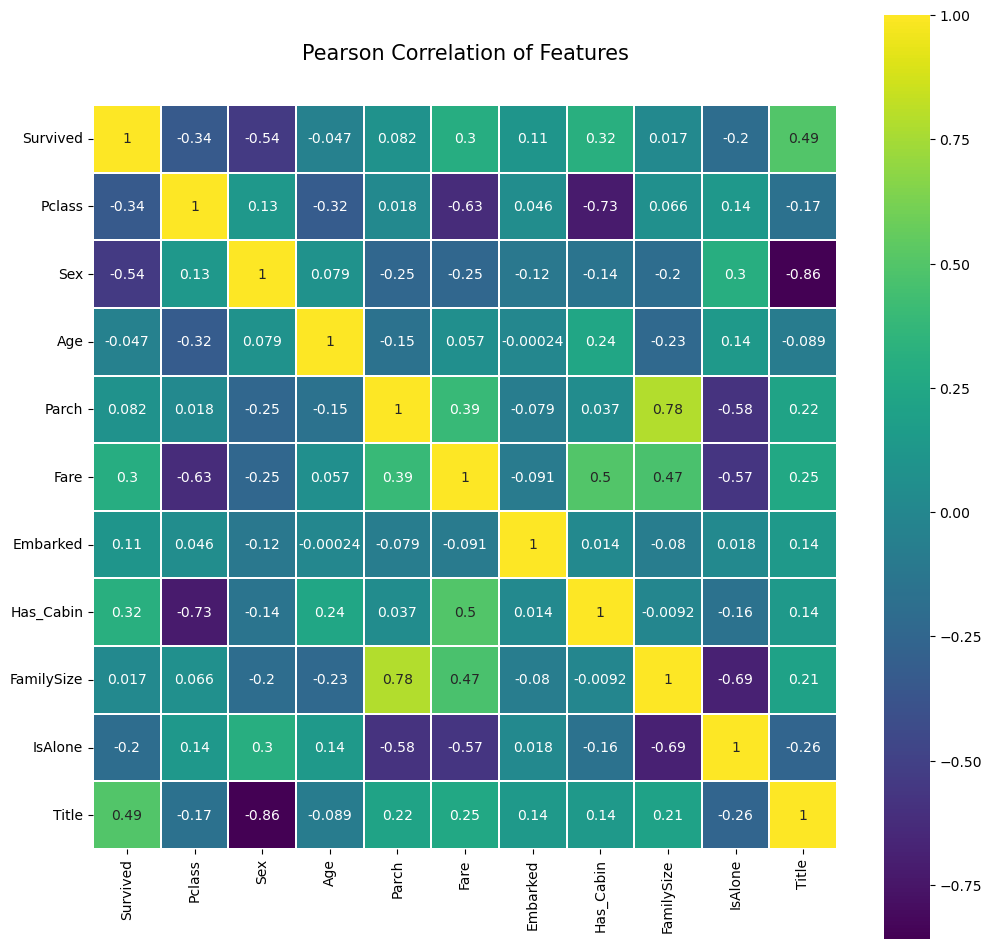

In [22]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0,
square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Współczynnik przeżywalności

In [23]:
train_data['Survived'].groupby(train_data['Title']).mean()

Title
1    0.156673
2    0.575000
3    0.793651
4    0.702703
5    0.347826
Name: Survived, dtype: float64

## Najlepsza głębokość drzewa decyzyjnego

In [24]:
x_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

model = DecisionTreeClassifier()

param_grid = {
    'max_depth': np.arange(3, 20),
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)  # 10-fold cross-validation

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Najlepsze parametry:", best_params)
print("Najlepsza dokładność:", best_score)

Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3}
Najlepsza dokładność: 0.8316479400749064


## Budowanie drzewa w oparciu o wyznaczone parametry

In [25]:
decision_tree = DecisionTreeClassifier(**best_params)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

## Predykcja możliwości przeżycia dla pasażerów ze zbioru testowego

In [26]:
predictions = decision_tree.predict(test_data)

results = pd.DataFrame({ 'Survived': predictions })

os.makedirs('out', exist_ok=True)
results.to_csv('out/predictions.csv')

## Wizualizacja drzewa decyzyjnego

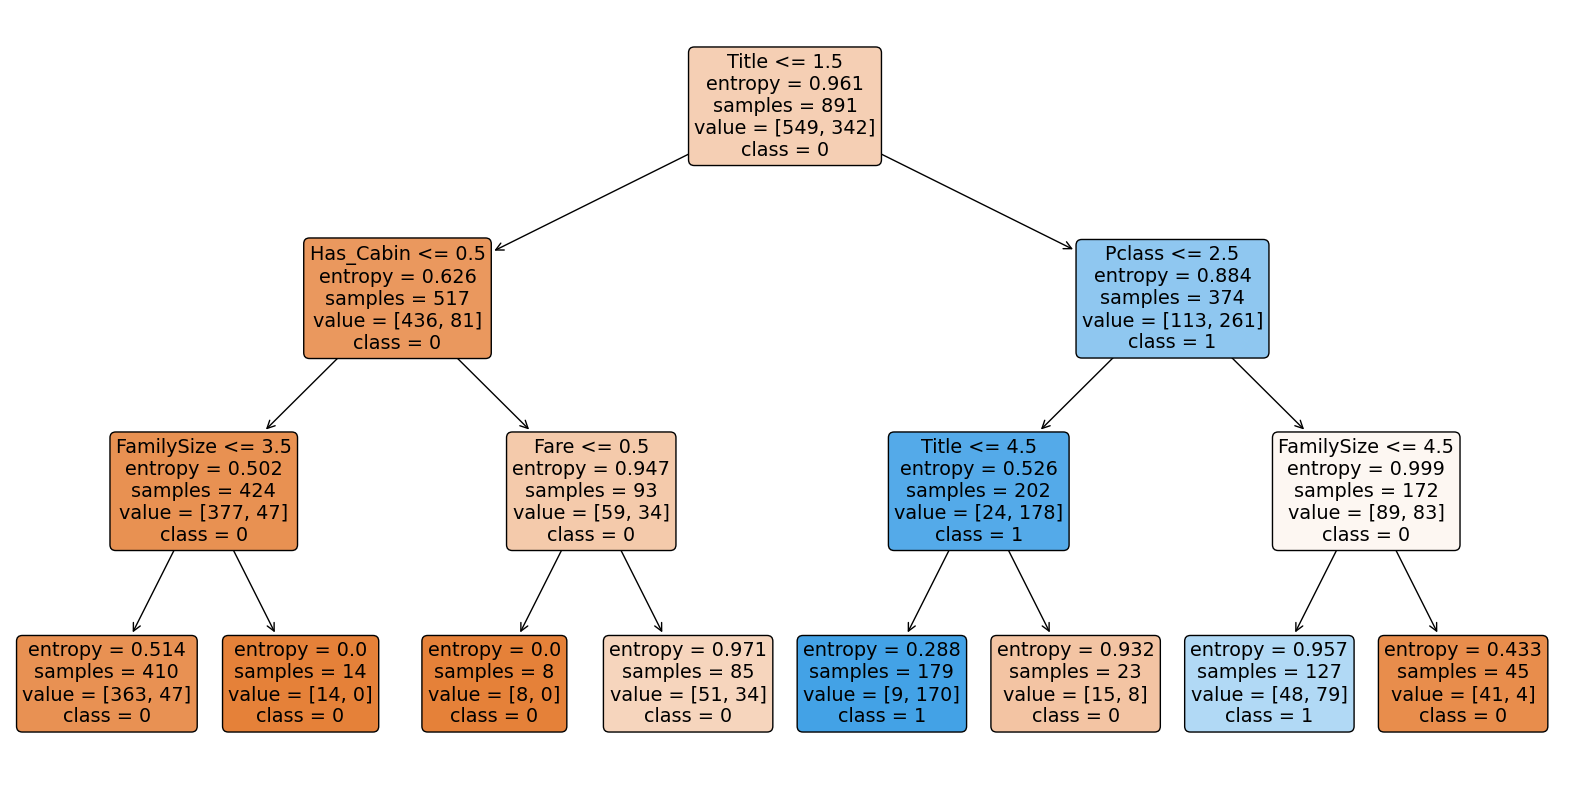

In [27]:
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree, 
    feature_names=list(train_data.columns[1:]),
    class_names=['0', '1'],
    filled=True,
    rounded=True
)
plt.show()

## Wpływ parametrów na dokładność klasyfikacji 

In [28]:
min_samples_leaf_values = [1, 5, 10, 20, 50, 100]
max_depth_values = [1, 2, 3, 5, 10, None]

### Pomocnicze funkcje

In [29]:
def evaluate_model(criterion):
    results = []
    for max_depth in max_depth_values:
        row = []
        for min_samples_leaf in min_samples_leaf_values:
            model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            scores = cross_val_score(model, x_train, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
            row.append(scores.mean())
        results.append(row)
    return pd.DataFrame(results, columns=min_samples_leaf_values, index=max_depth_values)

def plot_results(results, title, ax):
    sns.heatmap(results, annot=True, fmt=".2f", cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Min Samples Leaf')
    ax.set_ylabel('Max Depth')

### Wyznaczanie accuracy dla różnych parametrów

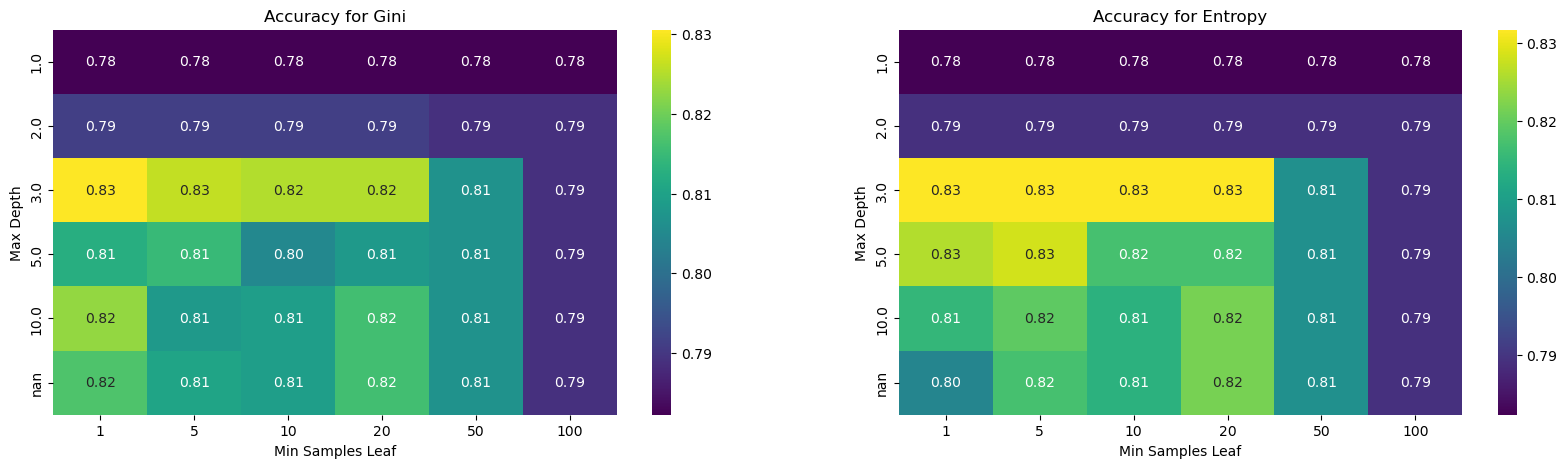

In [30]:
gini_results = evaluate_model('gini')
entropy_results = evaluate_model('entropy')

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_results(gini_results, "Accuracy for Gini", axes[0])
plot_results(entropy_results, "Accuracy for Entropy", axes[1])
plt.show()

## Podział zbioru treningowego na nowy zbiór treningowy oraz testowy

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25)

## Wizualizacja macierzy rozbieżności

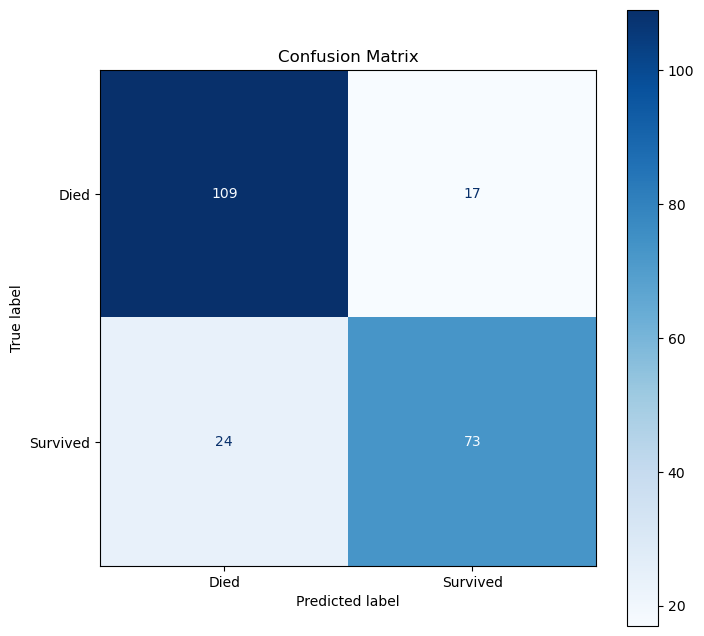

In [32]:
predictions = decision_tree.predict(x_test)
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died', 'Survived'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix') 
plt.show()

## Wyznaczanie miar jakości klasyfikatora 

### *accuracy*

In [33]:
accuracy_score(y_test, predictions)

0.8161434977578476

### *f1-score*

In [34]:
f1_score(y_test, predictions)

0.7807486631016044

### *average precision-recall*

In [35]:
probabilities = decision_tree.predict_proba(x_test)[:, 1] # Probability of survival (positive class)

precision, recall, _ = precision_recall_curve(y_test, probabilities)

print(f"Average Precision-Recall Score: {np.trapz(recall, precision):.2f}")

Average Precision-Recall Score: 0.45
